In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
normal_train.shape

(580, 28, 28, 3)

In [3]:
def get_training_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_train/(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_train/(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat(10).batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat(10).batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.map(lambda x: (x, [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat(10).batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.reduce_sum(x, axis=0), [1,0]))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

def get_testing_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test/(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test/(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat(10).batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat(10).batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.concat([x, y], axis=0), axis=0), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.map(lambda x: (x, [0,1]))
        dataset1 = dataset1.batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat(10).batch(n+1)
    if n > 0:
        dataset0 = dataset0.map(lambda x: (tf.reduce_sum(x, axis=0), [1,0]))
    else:
        dataset0 = dataset0.map(lambda x: (x, [1,0]))
    dataset0 = dataset0.shuffle(17).batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

In [4]:
def get_batch(iter0, iter1):
    x0, y0 = iter0.get_next()
    x1, y1 = iter1.get_next()
    x = tf.concat([x0,x1], axis=0)
    y = tf.concat([y0,y1], axis=0)
    return x, y

In [14]:
images, label = get_batch()
print(images.shape)
print(label.shape)

(?, 28, 28, 3)
(?, 2)


In [50]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.reshape(net, [batch_size, -1]) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    loss = tf.losses.softmax_cross_entropy(logits=net,onehot_labels=labels)
    return loss, net #return net to examine accuracy

In [51]:
batch_size = 32
loss, pred = CNN2(images, label, 2)
train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
prediction = tf.argmax(pred,-1) #returns the prediction
truth = tf.argmax(y,-1)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))

In [ ]:
train_it0, train_it1 = get_training_iterator()
test_it0, test_it1 = get_testing_iterator()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(iterator0.initializer)
sess.run(iterator1.initializer)

Accuracy = list()
for runs in range (5):
    train_losses = list()
    val_losses = list()
    start=time()
    for i in range(251):
        train_losses.append(sess.run(loss))
        if i%50==0:
            prediction = list()
            y_label = list()
            if superposition:
                val_losses.append(pass_through_validation_superposition(rawdata, prediction, y_label, numbatches=100))
            else:
                val_losses.append(pass_through_validation(prediction))
            print(i,train_losses[-1],val_losses[-1],time()-start)
    Accuracy.append(val_losses[-1])
mean = sum(Accuracy)/5
meanacc.append(mean)
mean

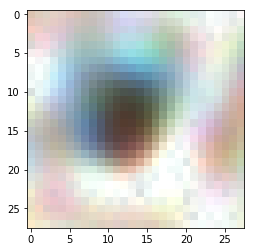

In [13]:
plt.imshow(sess.run(images)[16].astype(np.uint8))